In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
%matplotlib inline

In [ ]:
from google.colab import drive
import pandas as pd

# Google Drive mount
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import chardet

file_path = "/content/drive/MyDrive/2025 UTS Autumn Session/41180 Data Analytics for CyberSecurity/spam.csv"

# 파일의 인코딩 감지
with open(file_path, 'rb') as f:
    result = chardet.detect(f.read(100000))  # 처음 100,000 바이트만 검사
    encoding_type = result['encoding']

print(f"📌 감지된 인코딩: {encoding_type}")

# 감지된 인코딩으로 파일 읽기
sms = pd.read_csv(file_path, encoding=encoding_type)
print(sms.head())


📌 Detected encoding: Windows-1252
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [ ]:
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


**Drop unnamed columns and rename v1 and v2 to "Label" and "Message":**

In [ ]:
sms = sms.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
sms=sms.rename(columns={'v1':'Label', 'v2':'Message'})
sms.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
sms.groupby('Label').describe()

Message                                                               
        count unique                                                top freq
Label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

**Create new feature "Length" to show the length of each message**

In [ ]:
sms['length'] = sms['Message'].apply(len)
sms.head()

,Label,Message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

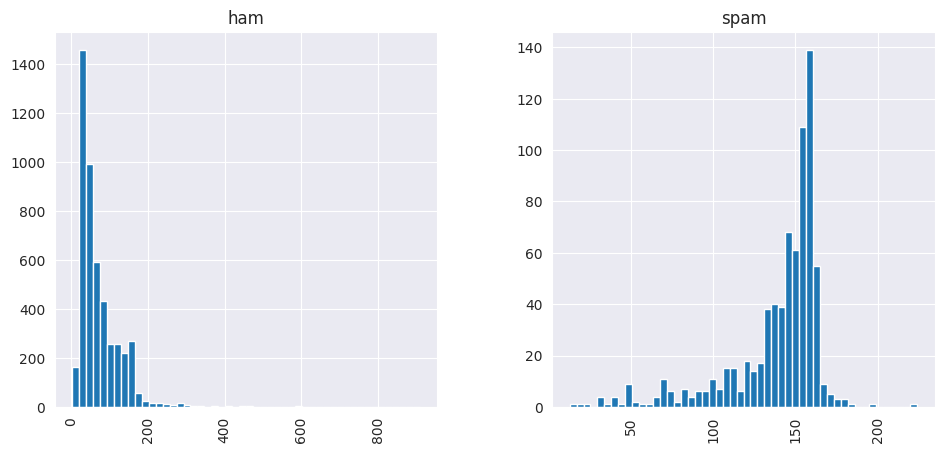

In [ ]:
mpl.rcParams['patch.force_edgecolor'] = True
sns.set_style('darkgrid')
sms.hist(column='length', by='Label', bins=50,figsize=(11,5))

In [ ]:
# 각 열의 미싱 밸류 개수 확인
missing_values = sms.isnull().sum()
print("미싱 밸류 개수:\n", missing_values)

# 전체 데이터셋에서 미싱 밸류가 있는 행 확인
missing_rows = sms[sms.isnull().any(axis=1)]
print("미싱 밸류가 포함된 행:\n", missing_rows)

미싱 밸류 개수:
 Label      0
Message    0
length     0
dtype: int64
미싱 밸류가 포함된 행:
 Empty DataFrame
Columns: [Label, Message, length]
Index: []


In [ ]:
# 두 컬럼 기준으로 중복된 행 찾기
duplicates = sms[sms.duplicated(subset=['Label', 'Message'], keep=False)]

# 정렬해서 중복된 행끼리 묶기
duplicates = duplicates.sort_values(by=['Label', 'Message']).reset_index()
duplicates

,index,Label,Message,length
0,1372,ham,1) Go to write msg 2) Put on Dictionary mode 3...,141
1,2162,ham,1) Go to write msg 2) Put on Dictionary mode 3...,141
2,2343,ham,1) Go to write msg 2) Put on Dictionary mode 3...,141
3,1469,ham,7 wonders in My WORLD 7th You 6th Ur style 5th...,153
4,1778,ham,7 wonders in My WORLD 7th You 6th Ur style 5th...,153
...,...,...,...,...
679,5035,spam,You won't believe it but it's true. It's Incre...,149
680,2832,spam,You've won tkts to the EURO2004 CUP FINAL or å...,111
681,3003,spam,You've won tkts to the EURO2004 CUP FINAL or å...,111
682,95,spam,Your free ringtone is waiting to be collected....,125


***Need to remove Duplicate Values based on the result above!!!!!***

In [ ]:
# ID 컬럼 추가 (1부터 시작하는 번호)
sms.insert(0, 'ID', range(1, len(sms) + 1))
sms.head()

,ID,Label,Message,length
0,1,ham,"Go until jurong point, crazy.. Available only ...",111
1,2,ham,Ok lar... Joking wif u oni...,29
2,3,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,4,ham,U dun say so early hor... U c already then say...,49
4,5,ham,"Nah I don't think he goes to usf, he lives aro...",61


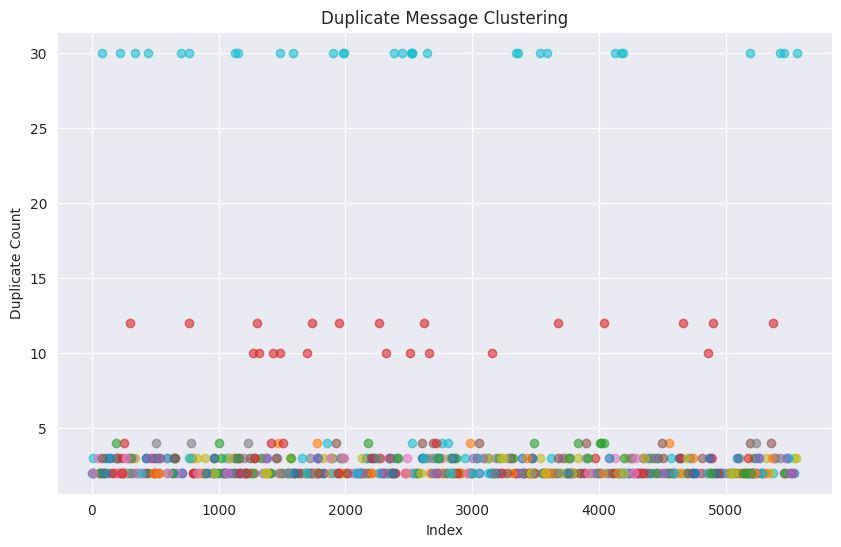

In [ ]:
# 중복된 행 찾기
duplicates =sms[sms.duplicated(subset=['Label', 'Message'], keep=False)]

# 중복된 값 개수 세기
dupe_counts = duplicates.groupby(['Label', 'Message']).size().reset_index(name='count')

# 각 중복된 값에 대한 인덱스 목록 가져오기
dupe_indices = duplicates.groupby(['Label', 'Message'])['ID'].apply(list).reset_index(name='indices')

# 데이터 합치기
dupe_counts = dupe_counts.merge(dupe_indices, on=['Label', 'Message'])

# 스캐터 플롯 그리기
plt.figure(figsize=(10, 6))
for _, row in dupe_counts.iterrows():
    indices = row['indices']
    count = row['count']
    plt.scatter(indices, [count] * len(indices), label=f"{row['Label']}, {row['Message']}", alpha=0.6)

plt.xlabel('Index')
plt.ylabel('Duplicate Count')
plt.title('Duplicate Message Clustering')
plt.legend([], [], frameon=False)  # 범례 숨김
plt.grid(True)
plt.show()

In [ ]:
# 제거된 행들의 ID 저장
removed_ids = sms.loc[sms.duplicated(subset=['Label', 'Message'], keep='first'), 'ID']

# 결과 출력
print("제거된 행들의 ID:")
print(removed_ids.tolist())

제거된 행들의 ID:
[103, 154, 207, 223, 326, 339, 357, 444, 533, 655, 658, 702, 768, 769, 775, 781, 790, 825, 850, 900, 963, 965, 1002, 1003, 1043, 1132, 1133, 1134, 1140, 1152, 1163, 1164, 1198, 1225, 1236, 1250, 1251, 1304, 1319, 1356, 1380, 1403, 1413, 1427, 1459, 1467, 1483, 1485, 1508, 1569, 1585, 1655, 1680, 1691, 1700, 1721, 1738, 1779, 1780, 1785, 1826, 1829, 1876, 1877, 1894, 1902, 1949, 1957, 1964, 1974, 1981, 1984, 1988, 1989, 1996, 2044, 2095, 2109, 2124, 2125, 2135, 2146, 2163, 2170, 2176, 2216, 2234, 2265, 2266, 2277, 2300, 2308, 2322, 2327, 2344, 2345, 2351, 2363, 2385, 2413, 2447, 2473, 2477, 2509, 2518, 2519, 2522, 2524, 2526, 2564, 2565, 2596, 2611, 2618, 2644, 2646, 2660, 2681, 2688, 2712, 2719, 2721, 2728, 2740, 2742, 2761, 2762, 2764, 2796, 2798, 2812, 2826, 2828, 2830, 2842, 2848, 2859, 2865, 2869, 2880, 2898, 2911, 2943, 2958, 2967, 2971, 2981, 2990, 2991, 3003, 3004, 3008, 3035, 3039, 3050, 3055, 3089, 3100, 3122, 3124, 3135, 3152, 3154, 3155, 3164, 3166, 3167, 3175, 3

In [ ]:
# 정제된 데이터셋 (남은 행들)
SMS = sms.loc[sms.duplicated(subset=['Label', 'Message'], keep='first') == False]

# 개수 계산
removed_count = len(removed_ids)

# 중복된 행 제거 후 남은 데이터셋
sms_cleaned = sms.loc[sms.duplicated(subset=['Label', 'Message'], keep='first') == False]

# 결과 출력
print(f"제거된 행 개수: {removed_count}")
print("남은 데이터셋:")
SMS

제거된 행 개수: 403
남은 데이터셋:


,ID,Label,Message,length
0,1,ham,"Go until jurong point, crazy.. Available only ...",111
1,2,ham,Ok lar... Joking wif u oni...,29
2,3,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,4,ham,U dun say so early hor... U c already then say...,49
4,5,ham,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...,...
5567,5568,spam,This is the 2nd time we have tried 2 contact u...,161
5568,5569,ham,Will Ì_ b going to esplanade fr home?,37
5569,5570,ham,"Pity, * was in mood for that. So...any other s...",57
5570,5571,ham,The guy did some bitching but I acted like i'd...,125


**Label Encoding 과정이 없으면 model training 시에 데이터 타입이 categorical data 로 지정되어 있어, Invalid dtype: object 오류가 발생함**

In [ ]:
# 스팸은 0, 햄은 1로 변환
SMS['Label_binary'] = SMS['Label'].map({'spam': 0, 'ham': 1})

# 변환 결과 확인
print(SMS[['Label', 'Label_binary']].head())

  Label  Label_binary
0   ham             1
1   ham             1
2  spam             0
3   ham             1
4   ham             1


<ipython-input-21-8904ec739c9f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SMS['Label_binary'] = SMS['Label'].map({'spam': 0, 'ham': 1})


In [ ]:
SMS = SMS.drop(['Label'], axis=1)
SMS


,ID,Message,length,Label_binary
0,1,"Go until jurong point, crazy.. Available only ...",111,1
1,2,Ok lar... Joking wif u oni...,29,1
2,3,Free entry in 2 a wkly comp to win FA Cup fina...,155,0
3,4,U dun say so early hor... U c already then say...,49,1
4,5,"Nah I don't think he goes to usf, he lives aro...",61,1
...,...,...,...,...
5567,5568,This is the 2nd time we have tried 2 contact u...,161,0
5568,5569,Will Ì_ b going to esplanade fr home?,37,1
5569,5570,"Pity, * was in mood for that. So...any other s...",57,1
5570,5571,The guy did some bitching but I acted like i'd...,125,1


In [ ]:
SMS

,ID,Label_binary,Message,length
0,1,1,"Go until jurong point, crazy.. Available only ...",111
1,2,1,Ok lar... Joking wif u oni...,29
2,3,0,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,4,1,U dun say so early hor... U c already then say...,49
4,5,1,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...,...
5567,5568,0,This is the 2nd time we have tried 2 contact u...,161
5568,5569,1,Will Ì_ b going to esplanade fr home?,37
5569,5570,1,"Pity, * was in mood for that. So...any other s...",57
5570,5571,1,The guy did some bitching but I acted like i'd...,125


In [ ]:
# 원하는 칼럼 이동
cols = SMS.columns.tolist()  # 칼럼 리스트로 변환
col_to_move = cols.pop(3)   # 5번째 칼럼(인덱스 4) 제거 후 저장
cols.insert(1, col_to_move) # 2번째 위치(인덱스 1)에 삽입

# 새로운 컬럼 순서 적용
SMS = SMS[cols]

# 확인
SMS.head()

,ID,Label_binary,Message,length
0,1,1,"Go until jurong point, crazy.. Available only ...",111
1,2,1,Ok lar... Joking wif u oni...,29
2,3,0,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,4,1,U dun say so early hor... U c already then say...,49
4,5,1,"Nah I don't think he goes to usf, he lives aro...",61


**Text Processigng and Vectorizing Our Messages**

In [ ]:
text_feat = SMS['Message'].copy()

In [ ]:
def text_process(text):

    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return " ".join(text)

**Text preprocessing and feature extraction for machine learning or NLP tasks**

In [ ]:
import nltk
nltk.download('stopwords')
text_feat = text_feat.apply(text_process)

vectorizer = TfidfVectorizer()

features = vectorizer.fit_transform(text_feat)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

**Following are some parameters in classification. In you assignment, you can try to adjust those parameters and observe their results. I would like to suggest you to discuss some links between the parameters and results. **

In [ ]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

In [ ]:
SMS

,ID,Label_binary,Message,length
0,1,1,"Go until jurong point, crazy.. Available only ...",111
1,2,1,Ok lar... Joking wif u oni...,29
2,3,0,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,4,1,U dun say so early hor... U c already then say...,49
4,5,1,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...,...
5567,5568,0,This is the 2nd time we have tried 2 contact u...,161
5568,5569,1,Will Ì_ b going to esplanade fr home?,37
5569,5570,1,"Pity, * was in mood for that. So...any other s...",57
5570,5571,1,The guy did some bitching but I acted like i'd...,125


In [ ]:
y = SMS["Label_binary"]  # 또는 "Spam", "target" 등의 올바른 레이블 컬럼으로 설정
print("y shape:", y.shape)  # 크기 확인

y shape: (5169,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Setting Tokeniser
tokenizer = Tokenizer(num_words=5000)     # Setting most frequent 5000 words
tokenizer.fit_on_texts(SMS["Message"])
X_seq = tokenizer.texts_to_sequences(SMS["Message"])
X_pad = pad_sequences(X_seq, maxlen=200)  # Padding Processing

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# Model Construction
model = Sequential([
    Embedding(5000, 128, input_length=200),
    SpatialDropout1D(0.2),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Excuting Model Learning
model.fit(X_train, y_train, epochs=7, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/7
130/130 ━━━━━━━━━━━━━━━━━━━━ 89s 621ms/step - accuracy: 0.8825 - loss: 0.3094 - val_accuracy: 0.9807 - val_loss: 0.0670
Epoch 2/7
130/130 ━━━━━━━━━━━━━━━━━━━━ 77s 591ms/step - accuracy: 0.9865 - loss: 0.0504 - val_accuracy: 0.9855 - val_loss: 0.0490
Epoch 3/7
130/130 ━━━━━━━━━━━━━━━━━━━━ 73s 561ms/step - accuracy: 0.9910 - loss: 0.0342 - val_accuracy: 0.9855 - val_loss: 0.0453
Epoch 4/7
130/130 ━━━━━━━━━━━━━━━━━━━━ 82s 560ms/step - accuracy: 0.9975 - loss: 0.0156 - val_accuracy: 0.9845 - val_loss: 0.0463
Epoch 5/7
130/130 ━━━━━━━━━━━━━━━━━━━━ 82s 561ms/step - accuracy: 0.9982 - loss: 0.0079 - val_accuracy: 0.9836 - val_loss: 0.0690
Epoch 6/7
130/130 ━━━━━━━━━━━━━━━━━━━━ 81s 555ms/step - accuracy: 0.9987 - loss: 0.0054 - val_accuracy: 0.9874 - val_loss: 0.0513
Epoch 7/7
130/130 ━━━━━━━━━━━━━━━━━━━━ 84s 570ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 0.9865 - val_loss: 0.0600


In [ ]:
import pandas as pd
import numpy as np

# 1. 모델이 테스트 데이터에 대해 예측 수행
y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()  # 0.5 기준으로 스팸/햄 분류

# 2. 스팸(0)과 햄(1) 데이터를 구분하여 인덱스 가져오기
spam_indices = np.where(y_test == 0)[0]  # 스팸(0) 데이터 인덱스
ham_indices = np.where(y_test == 1)[0]   # 햄(1) 데이터 인덱스

# 3. 스팸과 햄을 적절히 섞어서 15개 샘플 선택 (스팸 7개, 햄 8개 예제)
num_spam_samples = 11
num_ham_samples = 9

selected_spam_indices = np.random.choice(spam_indices, num_spam_samples, replace=False)
selected_ham_indices = np.random.choice(ham_indices, num_ham_samples, replace=False)

# 4. 선택한 인덱스를 합쳐서 샘플링
selected_indices = np.concatenate([selected_spam_indices, selected_ham_indices])
np.random.shuffle(selected_indices)  # 순서를 섞음

# 5. 원본 메시지, 실제 라벨, 예측 결과를 DataFrame으로 정리
results_df = pd.DataFrame({
    "Original Message": [SMS["Message"].iloc[i] for i in selected_indices],
    "Actual Label": [y_test.iloc[i] for i in selected_indices],  # 실제 라벨
    "Predicted Label": [y_pred[i] for i in selected_indices]  # 예측된 라벨
})

# 6. 출력
results_df

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step


,Original Message,Actual Label,Predicted Label
0,Customer place i will call you.,1,1
1,Finally the match heading towards draw as your...,1,1
2,WOT U WANNA DO THEN MISSY?,0,0
3,Dont gimme that lip caveboy,1,1
4,"Alright omw, gotta change my order to a half8th",0,0
5,"Sir, I have been late in paying rent for the p...",0,0
6,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,1,1
7,There generally isn't one. It's an uncountable...,0,0
8,All e best 4 ur driving tmr :-),1,1
9,U have a secret admirer who is looking 2 make ...,1,1


# F1 Score - 정밀도(Precision)와 재현율(Recall)의 조화 평균을 의미해. 클래스 불균형이 있을 때, 정확도만으로는 평가가 부족할 수 있기 때문에 F1-Score를 사용하는 것이 좋을 수 있어.

> 인용구 추가



33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step


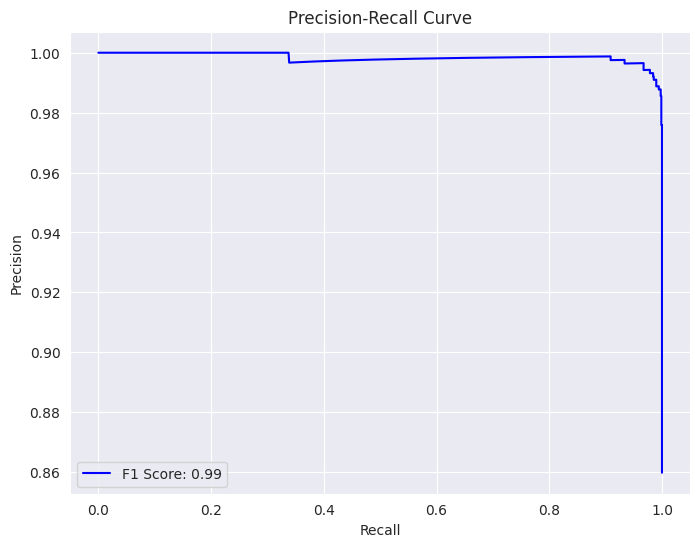

F1 Score: 0.9921612541993281


In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred)

#Providing PRC (Precisioin Recall Curve

from sklearn.metrics import precision_recall_curve

# y_test는 실제 레이블, y_pred는 모델 예측 확률
y_pred_prob = model.predict(X_test)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='b', label=f'F1 Score: {f1:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

print(f"F1 Score: {f1}")

위의 그래프에서 x축의 각 수치는 임곗값으로, 임계값을 변경하면서 재현율이 어떻게 변화하는지를 나타내는지를 보여주는 것!! (예를 들면 스팸 임곗값이 0.2 일 때는 0.2 이상인 값은 스팸으로 분류, 임곗값이 변하면 해당 임곗값 이상인 값을 스팸으로 분류)

**ROC Curve**

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


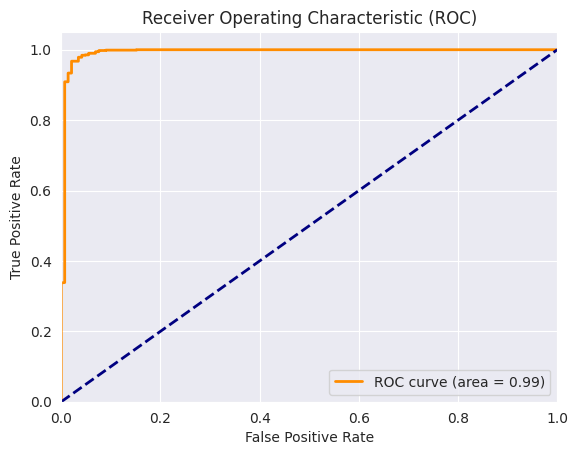

ROC AUC: 0.9932624801210194


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC curve 그리기
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)

# 그래프 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC: {roc_auc}")

Confusion Matrix:
[[134  11]
 [  3 886]]


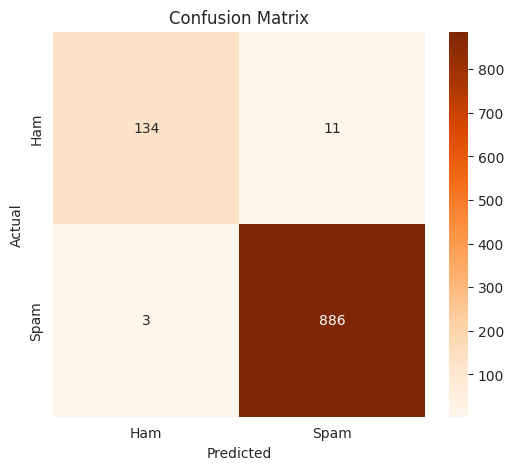

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# 예측값 (y_pred)과 실제값 (y_test)로 Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix 시각화 (히트맵)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])

# 제목과 축 레이블 설정
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 시각화 출력
plt.show()

True Positive (TP): 실제로 스팸(Spam)인데 스팸으로 예측한 경우
True Negative (TN): 실제로 햄(Ham)인데 햄으로 예측한 경우
False Positive (FP): 실제로 햄인데 스팸으로 예측한 경우
False Negative (FN): 실제로 스팸인데 햄으로 예측한 경우

**정밀도(Precision)와 재현율(Recall)은 특히 클래스 불균형 문제에서 중요한 평가 지표야. Precision은 모델이 예측한 긍정적 샘플 중 실제로 긍정적인 샘플의 비율이고, Recall은 실제 긍정적인 샘플 중 모델이 정확히 예측한 비율이야.**

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.987736900780379
Recall: 0.9966254218222722
